# Prior checks

We want to fully understand the location of the priors on $P$ and $i$, and make sure that we are actually obtaining prior information beyond this space.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('poster')
sns.set_palette('colorblind')
import pandas as pd
import astropy.units as u

## Set up priors

In [2]:
mu_xsplit = 0.75
sigma_xsplit = 0.75

npts = 10000

In [3]:
np.random.seed(11)
xsplit = np.random.lognormal(np.log(mu_xsplit), sigma_xsplit, size=npts)
cosi = np.random.uniform(0, 1, size=npts)
i = np.arccos(cosi)
split = xsplit/np.sin(i)
P = 1./(u.Quantity(split, u.microhertz).to(1/u.day)).value

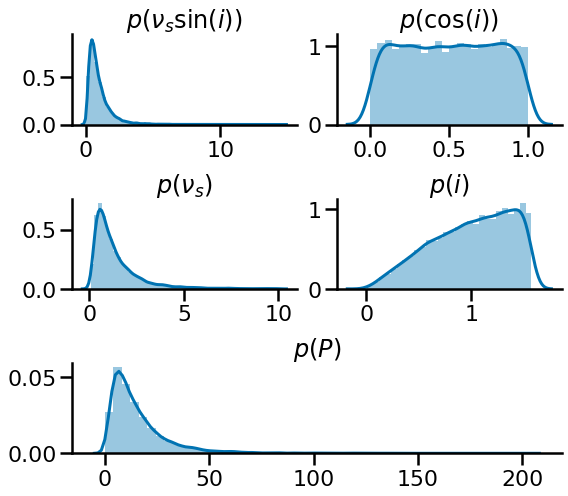

In [4]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(ax[0,0])
sns.distplot(xsplit, ax=ax0)
ax0.set_title(r'$p(\nu_s \sin(i))$')

ax1 = fig.add_subplot(ax[0,1])
sns.distplot(cosi, ax=ax1)
ax1.set_title(r'$p(\cos(i))$')

ax2 = fig.add_subplot(ax[1,0])
sns.distplot(split[split < 10], ax=ax2)
ax2.set_title(r'$p(\nu_s)$')

ax3 = fig.add_subplot(ax[1,1])
sns.distplot(i, ax=ax3)
ax3.set_title(r'$p(i)$')

ax4 = fig.add_subplot(ax[2,:])
sns.distplot(P, ax=ax4)
ax4.set_title(r'$p(P)$')

sns.despine()
fig.tight_layout()

plt.show()

## Let's check the location these priors take up in our data

In [5]:
ati = pd.read_csv('../../data/atium.csv',index_col=0)
ati = ati[np.isfinite(ati.nus.values)]
ati = ati.sort_values('age')
print(f'We have {len(ati)} stars with results right now.')

We have 92 stars with results right now.


## Period

In [6]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'corner_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp'],
      dtype='object')

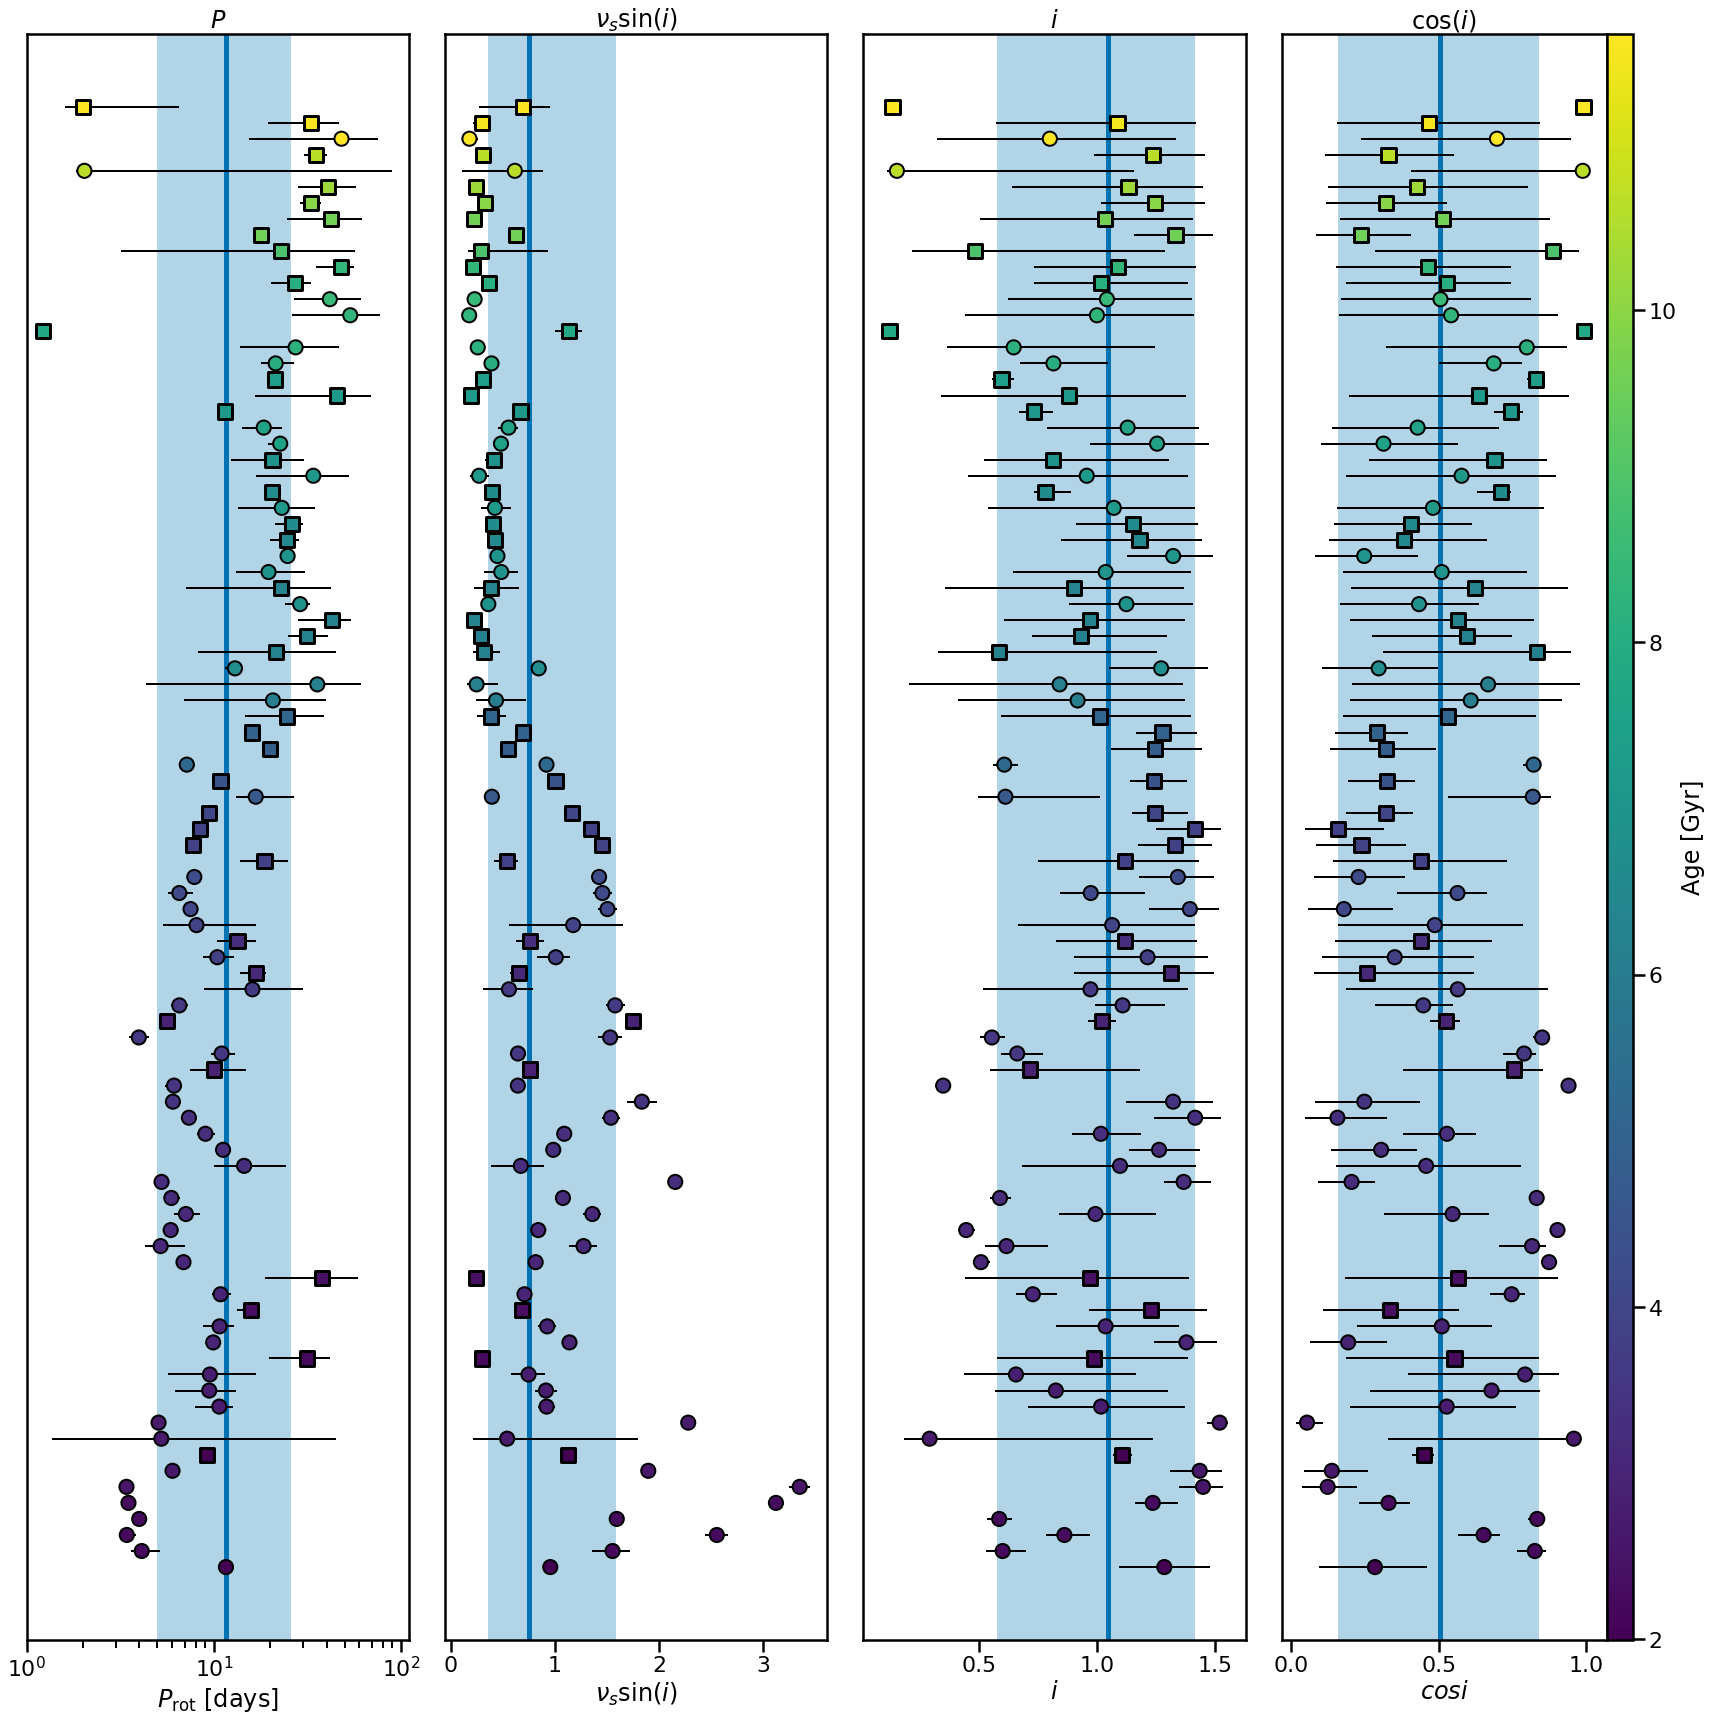

In [10]:
size = 200
ms = ati.hrclass == 'MS'
# flag = ati.eye_flag > 0

#Period
l, m, u = np.percentile(P, [16., 50., 84])

fig, axes = plt.subplots(1,4, figsize=(24,24))
ax = axes[0]
y = np.linspace(0, 1, len(ati))
c = ax.scatter(ati.P[~ms], y[~ms], c=ati.age[~ms], s=size, ec='k', lw=2, zorder=3)
c = ax.scatter(ati.P[ms], y[ms], c=ati.age[ms], s=size, ec='k', lw=3, marker=',', zorder=3)
# c = ax.scatter(ati.P[flag], y[flag], s=size-50, c='r',  zorder=3)

ax.errorbar(ati.P, y, c='k', lw=2, xerr=[ati.l_P, ati.u_P], yerr=None, fmt='_', zorder=2)

ax.fill_between(np.linspace(l, u), -0.05, 1.05, zorder=0, alpha=.3, label='p(P)')
ax.axvline(m, zorder=1, lw=5)
ax.set_xscale('log')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(1)
ax.set_xlabel(r'$P_{\rm rot}$ [days]')

#Inclination
l, m, u = np.percentile(i, [16., 50., 84])

ax1 = axes[2]
y = np.linspace(0, 1, len(ati))
c = ax1.scatter(ati.i[~ms], y[~ms], c=ati.age[~ms], s=size, ec='k', lw=2, zorder=3)
c = ax1.scatter(ati.i[ms], y[ms], c=ati.age[ms], s=size, ec='k', lw=3, marker=',', zorder=3)
# c = ax1.scatter(ati.i[flag], y[flag], s=size-50, c='r',  zorder=3)

ax1.errorbar(ati.i, y, c='k', lw=2, xerr=[ati.l_i, ati.u_i], yerr=None, fmt='_', zorder=2)

ax1.fill_between(np.linspace(l, u), -0.05, 1.05, zorder=0, alpha=.3, label='p(P)')
ax1.axvline(m, zorder=1, lw=5)

ax1.set_ylim(-0.05, 1.05)
ax1.set_xlabel(r'$i$')

#Projected Splitting
l, m, u = np.percentile(xsplit, [16., 50., 84])

ax2 = axes[1]
y = np.linspace(0, 1, len(ati))
c = ax2.scatter(ati['nus*'][~ms], y[~ms], c=ati.age[~ms], s=size, ec='k', lw=2, zorder=3)
c = ax2.scatter(ati['nus*'][ms], y[ms], c=ati.age[ms], s=size, ec='k', marker=',', lw=3, zorder=3)
# c = ax2.scatter(ati['nus*'][flag], y[flag], s=size-50, c='r',  zorder=3)

ax2.errorbar(ati['nus*'], y, c='k', lw=2, xerr=[ati['l_nus*'], ati['u_nus*']], yerr=None, fmt='_', zorder=2)

ax2.fill_between(np.linspace(l, u), -0.05, 1.05, zorder=0, alpha=.3, label='p(P)')
ax2.axvline(m, zorder=1, lw=5)

ax2.set_ylim(-0.05, 1.05)
ax2.set_xlabel(r'$\nu_s \sin(i)$')

#cos(i)
l, m, u = np.percentile(cosi, [16., 50.,84])

ax3 = axes[3]
y = np.linspace(0, 1, len(ati))
c = ax3.scatter(ati.cosi[~ms], y[~ms], c=ati.age[~ms], s=size, ec='k', lw=2, zorder=3)
c = ax3.scatter(ati.cosi[ms], y[ms], c=ati.age[ms], s=size, ec='k', marker=',', lw=3, zorder=3)
# c = ax3.scatter(ati.cosi[flag], y[flag], s=size-50, c='r',  zorder=3)
ax3.errorbar(ati.cosi, y, c='k', lw=2, xerr=[ati.l_cosi, ati.u_cosi], yerr=None, fmt='_', zorder=2)

ax3.fill_between(np.linspace(l, u), -0.05, 1.05, zorder=0, alpha=.3, label='p(P)')
ax3.axvline(m, zorder=1, lw=5)

ax3.set_ylim(-0.05, 1.05)
ax3.set_xlabel(r'$cosi$')

ax.set_title(r'$P$')
ax2.set_title(r'$\nu_s \sin(i)$')
ax1.set_title(r'$i$')
ax3.set_title(r'$\cos(i)$')
for a in axes:
    a.get_yaxis().set_visible(False)

fig.colorbar(c,label=r'Age [Gyr]', pad=0,aspect=60, ax=ax3)
fig.tight_layout()

It seems like $i$ is poorly constrained, which is expected. $\nu_s \sin(i)$ is the most tightly constrained, also as expected, and $P$ is for the most part well constrained after being subjected to the inclination angle probability function.

Why are some values (e.g. the 4th from the top) subject to uncertainties larger than the priors? Is this even possible?

**Question**: Should we be concerned when we sample the priors in $i$, but not in $P$? How does this bias our results on $P$?